In [1]:
import math
import os, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import datetime as dt

cwd = os.getcwd()
project_path = cwd[:cwd.find('pygents')+7]
if project_path not in sys.path: sys.path.append(project_path)
os.chdir(project_path)

if 'aigents_api' in sys.modules:
    del sys.modules['aigents_api']
if 'learn' in sys.modules:
    del sys.modules['learn']
if 'util' in sys.modules:
    del sys.modules['util']

from pygents.learn import count_ngrams_plus, count_ngrams_plus_tf_idf
from pygents.aigents_api import TextMetrics

model_family = 'binary_view_cleaned'
if not os.path.exists('data/models/distortions/split_babacan_test_train/'+model_family+'/'):
    os.makedirs('data/models/distortions/split_babacan_test_train/'+model_family+'/')    

grand_t0 = dt.datetime.now()

def language_metrics(metrics_list):
    metrics = {}
    for m in metrics_list:
        metrics[m] = 'data/models/distortions/split_babacan_test_train/'+model_family+'/' + m + '.txt'
    return metrics

In [ ]:
from datasets import Dataset

# dataset: https://huggingface.co/datasets/halilbabacan/autotrain-data-cognitive_distortions/tree/main

train_ds = Dataset.from_file("data/corpora/English/distortions/halilbabacan/train/data_train.arrow")
valid_ds = Dataset.from_file("data/corpora/English/distortions/halilbabacan/test/data_valid.arrow")

train_df = train_ds.to_pandas()

train_df = train_df.rename(columns={'text': 'Patient Question', 'target': 'Dominant Distortion'})
train_df.insert(1, "Distorted part", value = np.nan)
train_df.insert(3, "Secondary Distortion (Optional)", value = np.nan)
train_df['Dominant Distortion'] = train_df['Dominant Distortion'].map({
    1: 'Distortion',
    0: 'No Distortion'
})


valid_df = valid_ds.to_pandas()
valid_df = valid_df.rename(columns={'text': 'Patient Question', 'target': 'Dominant Distortion'})
valid_df.insert(1, "Distorted part", value = np.nan)
valid_df.insert(3, "Secondary Distortion (Optional)", value = np.nan)
valid_df['Dominant Distortion'] = valid_df['Dominant Distortion'].map({
    1: 'Distortion',
    0: 'No Distortion'
})

In [3]:
train_df

,Patient Question,Distorted part,Dominant Distortion,Secondary Distortion (Optional)
0,I have had a lot of change happen this last ye...,NaN,No Distortion,NaN
1,He knows but my parents do not My family is Mo...,NaN,No Distortion,NaN
2,Since I lived with my mother alone I have had ...,NaN,No Distortion,NaN
3,Hi and thank you I hate to say I’m desperate b...,NaN,Distortion,NaN
4,I’ve been impulsive and doing things that I re...,NaN,No Distortion,NaN
...,...,...,...,...
2816,Though they both see psychiatrists for meds ne...,NaN,No Distortion,NaN
2817,But since I trusted my mom these comments did ...,NaN,No Distortion,NaN
2818,Just when I thought I’ve won the seemingly end...,NaN,No Distortion,NaN
2819,I didn't hit my sales target I'm a bad salesp...,NaN,No Distortion,NaN


In [4]:
valid_df

,Patient Question,Distorted part,Dominant Distortion,Secondary Distortion (Optional)
0,From a 16 year old in Turkey: Over the past ye...,NaN,Distortion,NaN
1,I feel extremely anxious when doing tasks (eve...,NaN,No Distortion,NaN
2,Most of the times I can’t hold a normal conver...,NaN,No Distortion,NaN
3,I can't speak as many languages as my sister ...,NaN,No Distortion,NaN
4,I lack empathy and I don’t have very many clos...,NaN,No Distortion,NaN
...,...,...,...,...
701,A weirder example is when I got a second cat I...,NaN,No Distortion,NaN
702,My YouTube channel doesn't have many subscrib...,NaN,No Distortion,NaN
703,I tell myself it doesn’t really matter because...,NaN,No Distortion,NaN
704,I can't take photos like my brother I must no...,NaN,No Distortion,NaN


# Create training functions
### Functions for including key N-grams and creating model files

In [5]:
def ngrams_inclusion(model_ngram, ngram_inclusion_threshold):
    filtered_model_ngram = {}
    for distortion, ngram_dict in model_ngram.items():
        # Find the maximum metric value for the current distortion
        max_value = max(ngram_dict.values()) if ngram_dict else 0
        threshold_value = max_value * (ngram_inclusion_threshold / 100)

        # Filter n-grams that meet or exceed the threshold value
        filtered_model_ngram[distortion] = {
            ngram: metric for ngram, metric in ngram_dict.items() if metric >= threshold_value
        }
    return filtered_model_ngram


def create_model_files(filtered_model_ngram):
    # Create .txt files for each distortion
    output_dir = "data/models/distortions/split_babacan_test_train/"+model_family
    distortions_labels = []

    for distortion, ngrams in filtered_model_ngram.items():
        distortion_ = distortion.replace(" ", "_")
        file_path = f"{output_dir}/{distortion_}.txt"
        sorted_ngrams = sorted(ngrams.items(), key=lambda x: x[1], reverse=True) 
        distortions_labels.append(distortion)
        with open(file_path, "w", encoding="utf-8") as f:
            for ngram, metric_value in sorted_ngrams: 
                f.write(f"{' '.join(ngram)}\t{metric_value}\n")

    return (list(set(distortions_labels) - {'No Distortion'}))

### Evaluate functions

In [6]:
def f1_from_counts(true_positive, true_negative, false_positive, false_negative):
    precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0
    recall = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0
    return 2 * precision * recall / (precision + recall) if precision > 0 or recall > 0 else 0 

def evaluate_df_counts(df,evaluator,threshold, tm, debug=False):
    true_positive = 0
    true_negative = 0
    false_positive = 0
    false_negative = 0
    for _, row in df.iterrows():
        # Text definition: first, check the 2nd column; if NaN, take the text from the 1st column.
        text = row.iloc[1] if pd.notna(row.iloc[1]) else row.iloc[0]
        primary_distortion = row.iloc[2]  # The main cognitive distortion from the 3rd column
        secondary_distortion = row.iloc[3] if pd.notna(row.iloc[3]) else None  # The secondary distortion from the 4th column, if it exists
        ground_distortion = False if primary_distortion == 'No Distortion' else True
                       
        our_distortion = evaluator(text,threshold, tm)
        
        # https://en.wikipedia.org/wiki/F-score
        if ground_distortion == True and our_distortion == True:
            true_positive += 1
        if ground_distortion == False and our_distortion == True:
            false_positive += 1
        if ground_distortion == False and our_distortion == False:
            true_negative += 1
        if ground_distortion == True and our_distortion == False:
            false_negative += 1

        if debug:
            print(ground_distortion,our_distortion,text[:20],metrics)

    return true_positive, true_negative, false_positive, false_negative

def evaluate_df(df,evaluator,threshold,tm, debug=False):
    true_positive, true_negative, false_positive, false_negative = evaluate_df_counts(df,evaluator,threshold,tm,debug)
    return f1_from_counts(true_positive, true_negative, false_positive, false_negative)

def evaluate_df_acc_f1(df,evaluator,threshold,tm,debug=False):
    true_positive, true_negative, false_positive, false_negative = evaluate_df_counts(df,evaluator,threshold,tm,debug)
    return (true_positive + true_negative) / len(df), f1_from_counts(true_positive, true_negative, false_positive, false_negative) 

def our_evaluator(text,threshold, tm):
    metrics = tm.get_sentiment_words(text)
    if metrics.get('Distortion', 0) > threshold:
        return True
    return False

### Functions for analyzing the dataset and plot heatmaps

In [7]:
def matrix_plot(row_labels, col_labels, matrix, absmax, title=None, subtitle=None, vmin=None, vmax=None, dpi=None, titlefontsize=None, subtitlefontsize=None, width=20):
    plt.rcParams["figure.figsize"] = (width, len(row_labels) / 4)
    if dpi is not None:
        plt.rcParams["figure.dpi"] = dpi

    fig, ax = plt.subplots()

    p = sns.heatmap(matrix, ax=ax, xticklabels=col_labels, yticklabels=row_labels, 
                    vmin=-absmax if vmin is None else vmin, 
                    vmax=absmax if vmax is None else vmax, 
                    cmap='RdYlGn', annot=True)
    
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

    if title is not None:
        if titlefontsize is None:
            titlefontsize = 32 if len(title) < 50 else round(32 * 50 / len(title))
        ax.set_title(title, fontsize=titlefontsize, pad=20)

    if subtitle is not None:
        if subtitlefontsize is None:
            subtitlefontsize = round(titlefontsize * 0.7)
        ax.text(0.5, 1.01, subtitle, fontsize=subtitlefontsize, ha='center', va='bottom', transform=ax.transAxes)

    plt.show()    


def analyse_dataset(ngram_max, df_train, df_test, print_or_plot, ngram_selection_metric = None, ngram_inclusion_threshold = None):
    
    tfidf = count_ngrams_plus_tf_idf(df_train,ngram_max,binary=True)
    
    distortions, frequency, all_n_grams, frequency_self_normalized, unique_frequency, uniq_all_n_grams, n_gram_distortions, \
    norm_uniq_n_gram_dicts, n_gram_distortions_counts, norm, unique_frequency_self_normalized, norm_norm_uniq, norm_norm_uniq_norm, \
    norm_norm_uniq_norm_norm, fcr, cfr, mr, nl_mi, N = count_ngrams_plus(df_train,ngram_max,binary=True)
        
    selection_metrics = {
        'TF-IDF': tfidf,
        'F':frequency,
        'UF':unique_frequency,
        'FN':frequency_self_normalized,
        'UFN':unique_frequency_self_normalized,
        'UFN/D/D':norm_uniq_n_gram_dicts,
        'FN*UFN':norm_norm_uniq,
        'FN*UFN/D':norm_norm_uniq_norm,
        'CFR':cfr,
        'FCR':fcr,
        'MR':mr,
        'NLMI':nl_mi}
    
    ngram_inclusion_thresholds = [ngram_inclusion_threshold] if ngram_inclusion_threshold is not None else [90, 80, 70, 60, 50, 40, 30, 20, 10, 0]
    ngram_selection_metric = [ngram_selection_metric] if ngram_selection_metric is not None else list(selection_metrics.keys())
    
    for inclusion_threshold in ngram_inclusion_thresholds:
        for selection_metric in ngram_selection_metric:
            model_ngram = selection_metrics[selection_metric]
            
            # Filter out values below the threshold
            filtered_model_ngram = ngrams_inclusion(model_ngram, inclusion_threshold)

            # Create .txt files for each distortion
            distortions_labels = create_model_files(filtered_model_ngram)
            tm = TextMetrics(language_metrics(distortions_labels), encoding = "utf-8", debug=False)

            if print_or_plot == 'print_results':
                print('\nN-gram selection metric:', selection_metric)
                print('N-gram max length:', ngram_max)
                print('N-gram inclusion threshold:', inclusion_threshold)

                print('\tDetection threshold, accuracy, F1 score:')
    
            any_res_acc = {}
            any_res = {}
            for threshold in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
                acc, f1 = evaluate_df_acc_f1(df_test,our_evaluator,threshold, tm)
                any_res_acc[threshold] = acc
                any_res[threshold] = f1
                if print_or_plot == 'print_results':
                    print('\t', threshold, acc, f1)

            min_acc = min(any_res_acc.values())
            max_acc = max(any_res_acc.values())
            avg_acc = sum(any_res_acc.values()) / len(any_res_acc)

            min_f1 = min(any_res.values())
            max_f1 = max(any_res.values())
            avg_f1 = sum(any_res.values()) / len(any_res)

            if print_or_plot == 'print_results':
                print(f"\nAccuracy: min={min_acc}, max={max_acc}, avg={avg_acc}")
                print(f"F1 Score: min={min_f1}, max={max_f1}, avg={avg_f1}")
    
    return any_res_acc

# Grid search
### Perform a grid search over all hyper-parameters to determine the best combination for building the model

In [8]:
ngram_selection_metrics = ['TF-IDF','F','UF','FN','UFN','UFN/D/D','FN*UFN','FN*UFN/D','CFR','FCR','MR','NLMI']
ngram_max_values = [1, 2, 3, 4]
ngram_inclusion_thresholds = [90, 80, 70, 60, 50, 40, 30, 20, 10, 0]

for ngram_max in ngram_max_values:
    acc_data = analyse_dataset(ngram_max, train_df, valid_df, 'print_results')


N-gram selection metric: TF-IDF
N-gram max length: 1
N-gram inclusion threshold: 90
	Detection threshold, accuracy, F1 score:
	 0.1 0.7436260623229461 0.3864406779661017
	 0.2 0.7308781869688386 0.32142857142857145
	 0.3 0.7252124645892352 0.23015873015873017
	 0.4 0.726628895184136 0.13452914798206278
	 0.5 0.7294617563739377 0.020512820512820513
	 0.6 0.7337110481586402 0
	 0.7 0.7351274787535411 0
	 0.8 0.7351274787535411 0
	 0.9 0.7351274787535411 0

Accuracy: min=0.7252124645892352, max=0.7436260623229461, avg=0.732766761095373
F1 Score: min=0, max=0.3864406779661017, avg=0.12145221644980962

N-gram selection metric: F
N-gram max length: 1
N-gram inclusion threshold: 90
	Detection threshold, accuracy, F1 score:
	 0.1 0.36827195467422097 0.42966751918158574
	 0.2 0.34419263456090654 0.3867549668874172
	 0.3 0.34277620396600567 0.34090909090909094
	 0.4 0.34277620396600567 0.2564102564102564
	 0.5 0.4830028328611898 0.09876543209876544
	 0.6 0.6784702549575071 0
	 0.7 0.72946175637

### Our best model obtained through the optimal combination of hyper-parameters

In [13]:
# Best model
acc_data = analyse_dataset(1, train_df, valid_df, 'print_results', 'FN', 60)


N-gram selection metric: FN
N-gram max length: 1
N-gram inclusion threshold: 60
	Detection threshold, accuracy, F1 score:
	 0.1 0.29320113314447593 0.42840778923253153
	 0.2 0.29320113314447593 0.42840778923253153
	 0.3 0.29320113314447593 0.42840778923253153
	 0.4 0.29461756373937675 0.4288990825688073
	 0.5 0.3555240793201133 0.451145958986731
	 0.6 0.4093484419263456 0.47281921618204803
	 0.7 0.5084985835694051 0.5187239944521498
	 0.8 0.6345609065155807 0.5904761904761905
	 0.9 0.8328611898016998 0.6628571428571428

Accuracy: min=0.29320113314447593, max=0.8328611898016998, avg=0.4350015738117721
F1 Score: min=0.42840778923253153, max=0.6628571428571428, avg=0.4900161059134071


# Plot heatmaps 
## Plot heatmaps illustrating the search for optimal hyperparameters

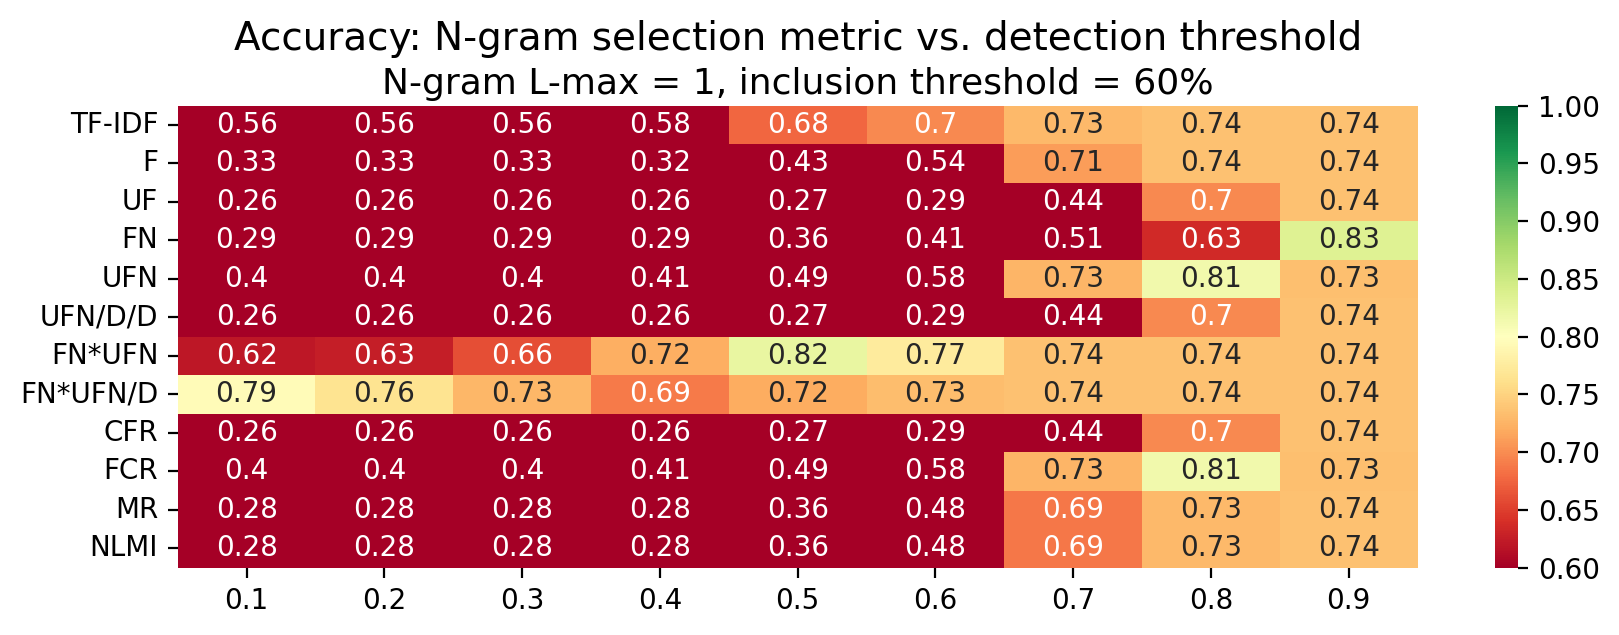

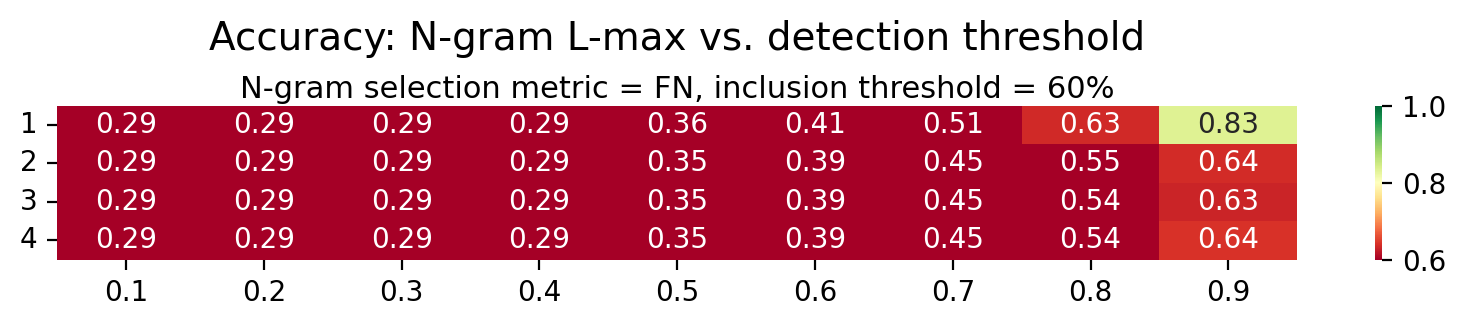

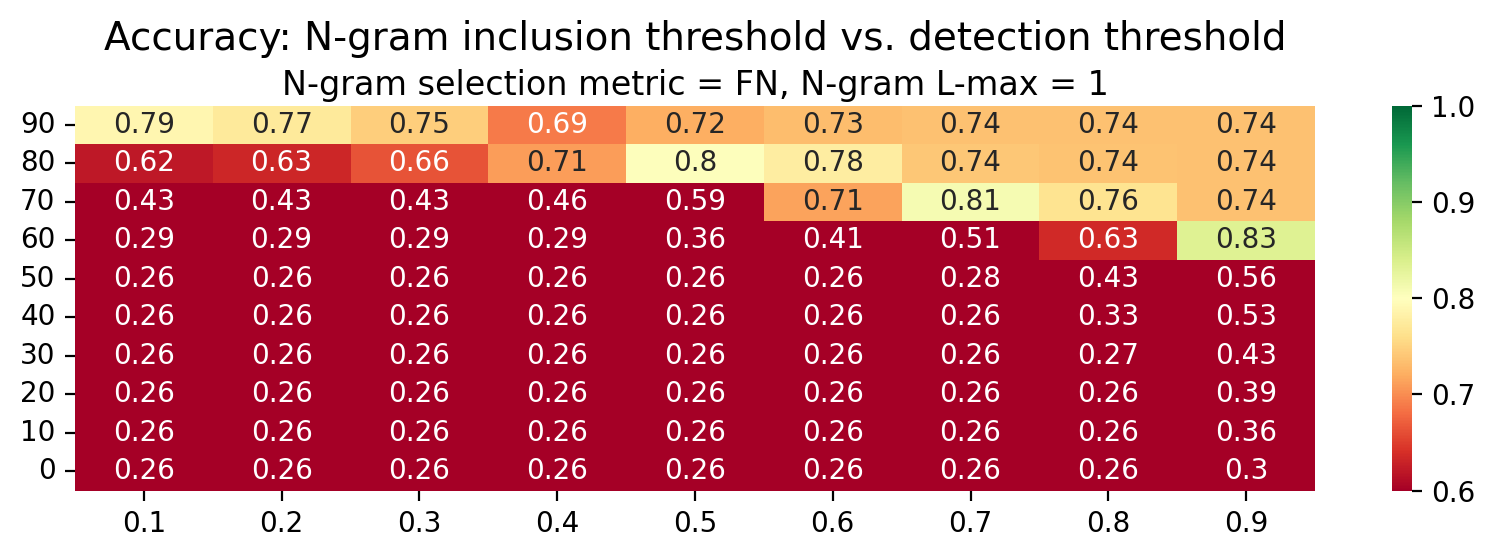

In [14]:
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

# 1) N-gram selection metric - threshold
acc_analytics_threshold = np.zeros((len(ngram_selection_metrics), len(thresholds)))
for i, ngram_selection_metric in enumerate(ngram_selection_metrics):
    acc_data = analyse_dataset(1, train_df, valid_df, 'plot_results', ngram_selection_metric, 60)
    for j, threshold in enumerate(thresholds):
        acc_analytics_threshold[i, j] = acc_data[threshold]

matrix_plot(
    ngram_selection_metrics, thresholds, acc_analytics_threshold, 1.0,
    title="Accuracy: N-gram selection metric vs. detection threshold",
    subtitle="N-gram L-max = 1, inclusion threshold = 60%",
    vmin=1.0 - (1.0 - 0.8) * 2, vmax=1.0, titlefontsize=14, subtitlefontsize=13,
    dpi=200, width=10
)


# 2) ngram_max - threshold
acc_ngrammax_threshold = np.zeros((len(ngram_max_values), len(thresholds)))
for i, ngram_max in enumerate(ngram_max_values):
    acc_data = analyse_dataset(ngram_max, train_df, valid_df, 'plot_results', ngram_selection_metric = 'FN', ngram_inclusion_threshold = 60)
    for j, threshold in enumerate(thresholds):
        acc_ngrammax_threshold[i, j] = acc_data[threshold]

matrix_plot(
    ngram_max_values, thresholds, acc_ngrammax_threshold, 1.0,
    title="Accuracy: N-gram L-max vs. detection threshold",
    subtitle="N-gram selection metric = FN, inclusion threshold = 60%",
    vmin=1.0 - (1.0 - 0.8) * 2, vmax=1.0, titlefontsize=14, subtitlefontsize=11,
    dpi=200, width=10
)

            
# 3) ngram_inclusion_threshold - threshold
acc_ngram_inclusion_threshold = np.zeros((len(ngram_inclusion_thresholds), len(thresholds)))

for i, ngram_inclusion_threshold in enumerate(ngram_inclusion_thresholds):
    acc_data = analyse_dataset(1, train_df, valid_df, 'plot_results', 'FN', ngram_inclusion_threshold)
    for j, threshold in enumerate(thresholds):
        acc_ngram_inclusion_threshold[i, j] = acc_data[threshold]

matrix_plot(
    ngram_inclusion_thresholds, thresholds, acc_ngram_inclusion_threshold, 1.0,
    title="Accuracy: N-gram inclusion threshold vs. detection threshold",
    subtitle="N-gram selection metric = FN, N-gram L-max = 1",
    vmin=1.0 - (1.0 - 0.8) * 2, vmax=1.0, titlefontsize=14, subtitlefontsize=12,
    dpi=200, width=10
)

In [8]:
# Best model
acc_data = analyse_dataset(1, train_df, valid_df, 'print_results', 'FN', 60)


N-gram selection metric: FN
N-gram max length: 1
N-gram inclusion threshold: 60
	Detection threshold, accuracy, F1 score:
	 0.1 0.29320113314447593 0.42840778923253153
	 0.2 0.29320113314447593 0.42840778923253153
	 0.3 0.29320113314447593 0.42840778923253153
	 0.4 0.29461756373937675 0.4288990825688073
	 0.5 0.3555240793201133 0.451145958986731
	 0.6 0.4093484419263456 0.47281921618204803
	 0.7 0.5084985835694051 0.5187239944521498
	 0.8 0.6345609065155807 0.5904761904761905
	 0.9 0.8328611898016998 0.6628571428571428

Accuracy: min=0.29320113314447593, max=0.8328611898016998, avg=0.4350015738117721
F1 Score: min=0.42840778923253153, max=0.6628571428571428, avg=0.4900161059134071


In [12]:
grand_t1 = dt.datetime.now()
grand_delta = grand_t1 - grand_t0
str(grand_delta)

'0:52:20.052600'